@misc{chollet2015keras,
  title={Keras},
  author={Chollet, Fran\c{c}ois and others},
  year={2015},
  howpublished={\url{https://keras.io}},
}

In [1]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm

2023-08-10 21:10:46.513900: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading the Data

In [2]:
class_names = ['2lanes_npy', 
               '3lanes_npy', 
               'crossing_npy', 
               'split4lanes_npy', 
               'split6lanes_npy', 
               'transition_npy']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (124, 124) #(100, 80)

In [3]:
def local_file(file_name):
    #script_dir = os.path.dirname(os.path.abspath(__file__))
    data_file_path = os.path.join('input_02', file_name)
    return data_file_path

def load_data():
    """
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images to evaluate how accurately the network learned to classify images.
    """
    
    datasets = [local_file('train_data'), local_file('test_data')]
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            if folder != '.DS_Store':
                label = class_names_label[folder]
                
                # Iterate through each image in our folder
                for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                    
                    # Get the path name of the image
                    img_path = os.path.join(os.path.join(dataset, folder), file)
                    
                    # Open and resize the img
                    #image = cv2.imread(img_path)
                    image = np.load(img_path)
                    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    image = cv2.resize(image, IMAGE_SIZE) 
                    
                    # Append the image and its corresponding label to the output
                    images.append(image)
                    labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [4]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading /Users/emadaldoghry/Repo/Classification-of-number-of-lanes-transition-areas-and-crossing-from-point-clouds/dataset/input_02/train_data


  0%|          | 0/209 [00:00<?, ?it/s]

100%|██████████| 155/155 [00:00<00:00, 488.97it/s]


Loading /Users/emadaldoghry/Repo/Classification-of-number-of-lanes-transition-areas-and-crossing-from-point-clouds/dataset/input_02/test_data


100%|██████████| 9/9 [00:00<00:00, 455.61it/s]


In [5]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [6]:
train_images.shape

(1351, 124, 124, 15)

Explore the dataset

In [7]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
#print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 1351
Number of testing examples: 74


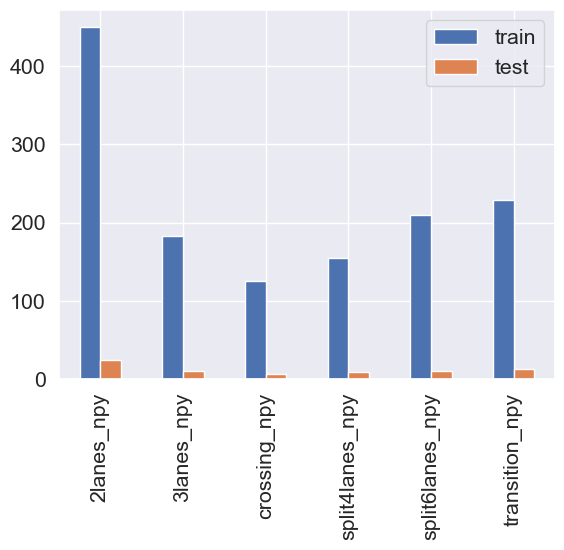

In [8]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

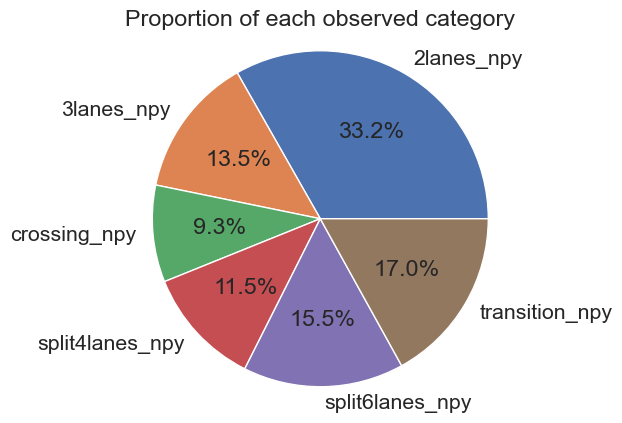

In [9]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

In [10]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index][:,:,:3])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

Visualize the data

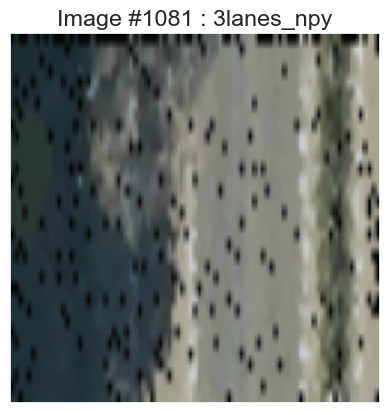

In [11]:
display_random_image(class_names, train_images, train_labels)

In [12]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i][:,:,:3], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

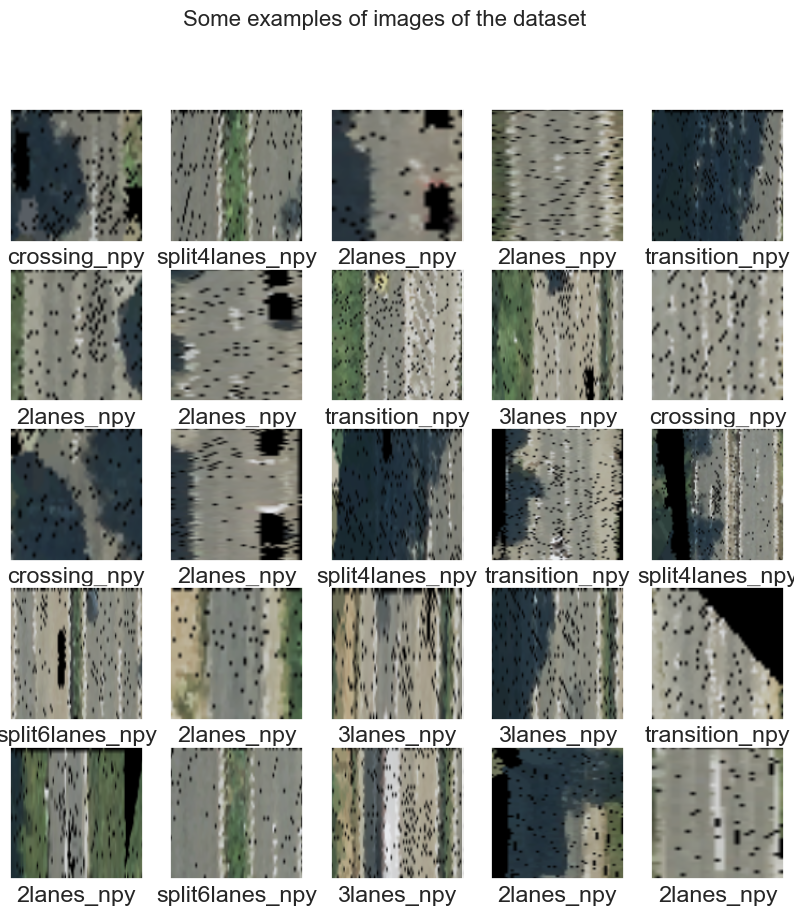

In [13]:
display_examples(class_names, train_images, train_labels)

Model Creation

In [14]:
# Build the model 
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(124, 124, 15)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

In [15]:
# Compile the model
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 122, 122, 64)      8704      
                                                                 
 max_pooling2d (MaxPooling2  (None, 61, 61, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 59, 59, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 29, 29, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 27, 27, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 13, 13, 256)       0

In [17]:
# Train / fit the data to the model
history = model.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split = 0.2)

Epoch 1/20
9/9 [==============================] - 51s 5s/step - loss: 2.0625 - accuracy: 0.2519 - val_loss: 1.6772 - val_accuracy: 0.3210
Epoch 2/20
9/9 [==============================] - 47s 5s/step - loss: 1.5880 - accuracy: 0.3704 - val_loss: 1.5166 - val_accuracy: 0.4391
Epoch 3/20
9/9 [==============================] - 55s 6s/step - loss: 1.5082 - accuracy: 0.4259 - val_loss: 1.4613 - val_accuracy: 0.4576
Epoch 4/20
9/9 [==============================] - 48s 5s/step - loss: 1.4430 - accuracy: 0.4722 - val_loss: 1.3812 - val_accuracy: 0.4871
Epoch 5/20
9/9 [==============================] - 49s 5s/step - loss: 1.3055 - accuracy: 0.5204 - val_loss: 1.2014 - val_accuracy: 0.5572
Epoch 6/20
9/9 [==============================] - 40s 4s/step - loss: 1.1792 - accuracy: 0.5574 - val_loss: 1.1344 - val_accuracy: 0.5535
Epoch 7/20
9/9 [==============================] - 45s 5s/step - loss: 1.0965 - accuracy: 0.5741 - val_loss: 1.0359 - val_accuracy: 0.5830
Epoch 8/20
9/9 [==================

In [18]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

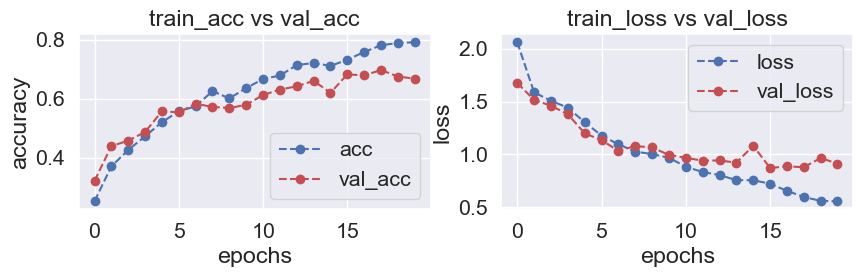

In [19]:
# Evaluate the model on the testing set
plot_accuracy_loss(history)

In [20]:
test_loss = model.evaluate(test_images, test_labels)

3/3 [==============================] - 1s 178ms/step - loss: 1.0128 - accuracy: 0.6081


Error analysis

3/3 [==============================] - 1s 184ms/step


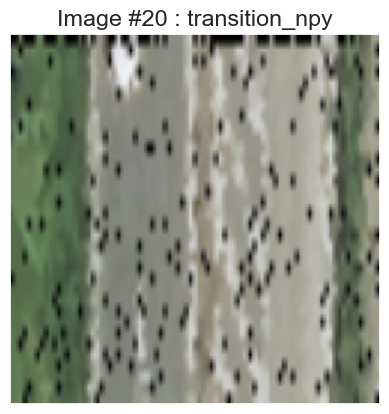

In [21]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

display_random_image(class_names, test_images, pred_labels)

In [22]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        Print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
    """
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)

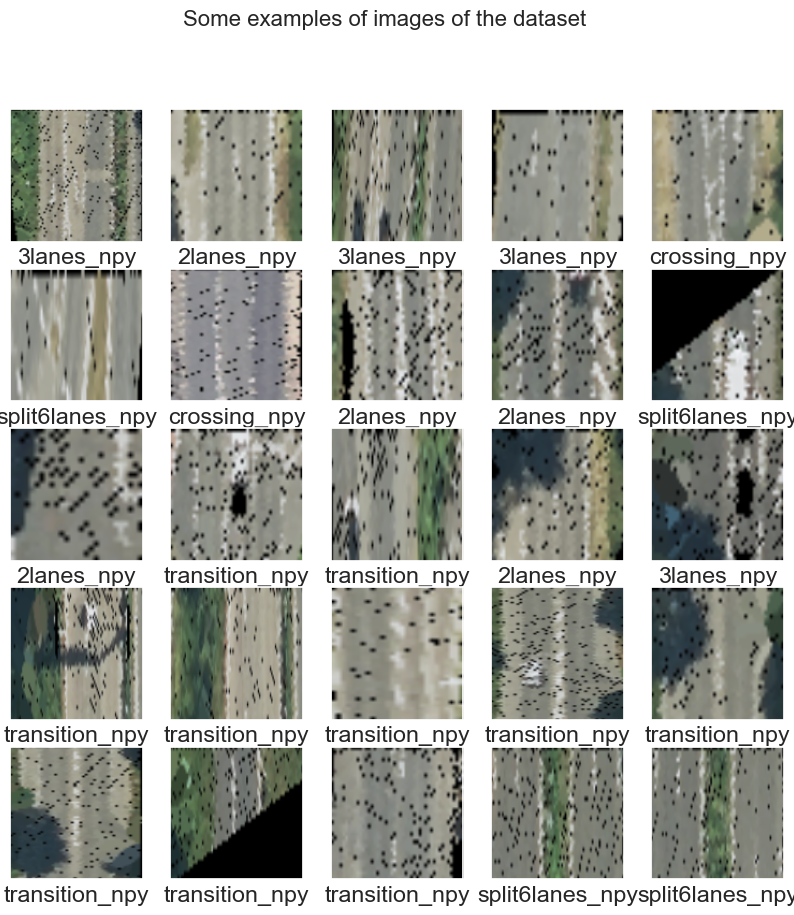

In [23]:
# on which kind of images the classifier has trouble
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

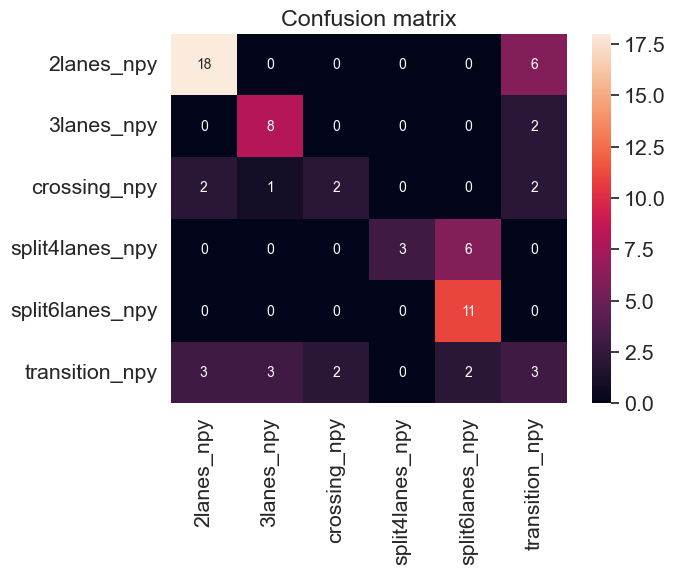

In [24]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

Try to use predesigned models

In [25]:
# first try: use VGG16
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Input

input_layer = Input(shape=(124, 124, 15))
model = tf.keras.applications.vgg16.VGG16(include_top=False, weights= None, input_tensor=input_layer)



In [26]:
# second try: Xception
input_layer = Input(shape=(124, 124, 15))
model = tf.keras.applications.Xception(
        include_top=False,
        weights=None,
        input_tensor=input_layer,
        input_shape=None,
        pooling=None,
        classes=1000,
        classifier_activation="softmax",
        )

In [27]:
# thrid try: InceptionResNetV2
input_layer = Input(shape=(124, 124, 15))
tf.keras.applications.InceptionResNetV2(
    include_top=False,
    weights= None,
    input_tensor=input_layer,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax"
)

In [28]:
# get features from pre designed model
train_features = model.predict(train_images)
test_features = model.predict(test_images)

3/3 [==============================] - 1s 361ms/step


Visulize the features through Principal component analysis

In [29]:
n_train, x, y, z = train_features.shape
n_test, x, y, z = test_features.shape
numFeatures = x * y * z

In [30]:
from sklearn import decomposition

pca = decomposition.PCA(n_components = 2)

X = train_features.reshape((n_train, x*y*z))
pca.fit(X)

C = pca.transform(X) # Représentation des individus dans les nouveaux axe
C1 = C[:,0]
C2 = C[:,1]

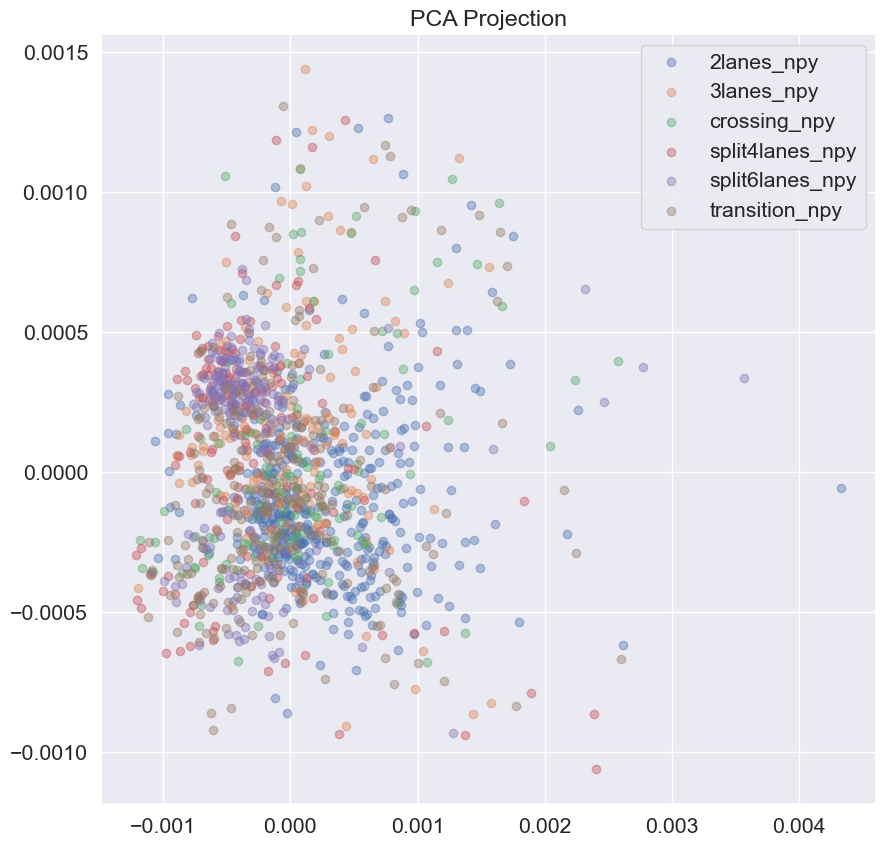

In [31]:
### Figures

plt.subplots(figsize=(10,10))

for i, class_name in enumerate(class_names):
    plt.scatter(C1[train_labels == i][:1000], C2[train_labels == i][:1000], label = class_name, alpha=0.4)
plt.legend()
plt.title("PCA Projection")
plt.show()

No clear clusters are identified

one-layer Neural Network on the extracted features 

In [32]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (x, y, z)),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

history2 = model2.fit(train_features, train_labels, batch_size=128, epochs=15, validation_split = 0.2)

Epoch 1/15
9/9 [==============================] - 1s 71ms/step - loss: 1.7880 - accuracy: 0.3185 - val_loss: 1.7830 - val_accuracy: 0.3100
Epoch 2/15
9/9 [==============================] - 0s 29ms/step - loss: 1.7779 - accuracy: 0.3380 - val_loss: 1.7735 - val_accuracy: 0.3100
Epoch 3/15
9/9 [==============================] - 0s 26ms/step - loss: 1.7672 - accuracy: 0.3380 - val_loss: 1.7629 - val_accuracy: 0.3100
Epoch 4/15
9/9 [==============================] - 0s 23ms/step - loss: 1.7555 - accuracy: 0.3380 - val_loss: 1.7527 - val_accuracy: 0.3100
Epoch 5/15
9/9 [==============================] - 0s 22ms/step - loss: 1.7435 - accuracy: 0.3380 - val_loss: 1.7425 - val_accuracy: 0.3100
Epoch 6/15
9/9 [==============================] - 0s 22ms/step - loss: 1.7321 - accuracy: 0.3380 - val_loss: 1.7331 - val_accuracy: 0.3100
Epoch 7/15
9/9 [==============================] - 0s 21ms/step - loss: 1.7221 - accuracy: 0.3380 - val_loss: 1.7248 - val_accuracy: 0.3100
Epoch 8/15
9/9 [===========

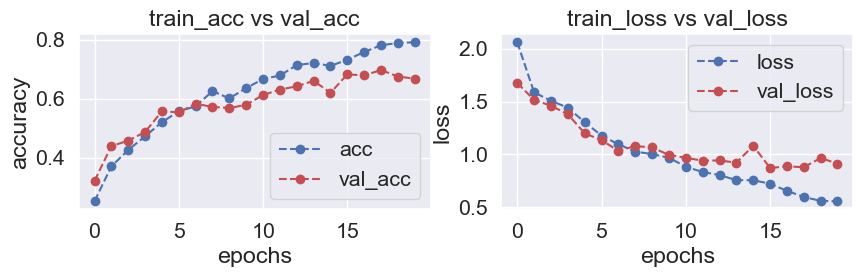

In [33]:
plot_accuracy_loss(history)

In [34]:
test_loss = model2.evaluate(test_features, test_labels)

3/3 [==============================] - 0s 3ms/step - loss: 1.7058 - accuracy: 0.3243


Ensemble Neural Networks
define n_estimators Neural Networks.
Each Neural Network will be trained on random subsets of the training dataset. Each subset contains max_samples samples.

In [35]:
np.random.seed(seed=1997)
# Number of estimators
n_estimators = 10
# Proporition of samples to use to train each training
max_samples = 0.8

max_samples *= n_train
max_samples = int(max_samples)

In [36]:
models = list()
random = np.random.randint(50, 100, size = n_estimators)

for i in range(n_estimators):
    
    # Model
    model = tf.keras.Sequential([ tf.keras.layers.Flatten(input_shape = (x, y, z)),
                                # One layer with random size
                                    tf.keras.layers.Dense(random[i], activation=tf.nn.relu),
                                    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
                                ])
    
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Store model
    models.append(model)

In [37]:
histories = []

for i in range(n_estimators):
    # Train each model on a bag of the training data
    train_idx = np.random.choice(len(train_features), size = max_samples)
    histories.append(models[i].fit(train_features[train_idx], train_labels[train_idx], batch_size=128, epochs=10, validation_split = 0.1))

Epoch 1/10
8/8 [==============================] - 1s 65ms/step - loss: 1.7881 - accuracy: 0.3004 - val_loss: 1.7863 - val_accuracy: 0.2500
Epoch 2/10
8/8 [==============================] - 0s 33ms/step - loss: 1.7784 - accuracy: 0.3282 - val_loss: 1.7803 - val_accuracy: 0.2500
Epoch 3/10
8/8 [==============================] - 0s 28ms/step - loss: 1.7680 - accuracy: 0.3282 - val_loss: 1.7742 - val_accuracy: 0.2500
Epoch 4/10
8/8 [==============================] - 0s 27ms/step - loss: 1.7572 - accuracy: 0.3282 - val_loss: 1.7682 - val_accuracy: 0.2500
Epoch 5/10
8/8 [==============================] - 0s 30ms/step - loss: 1.7455 - accuracy: 0.3282 - val_loss: 1.7631 - val_accuracy: 0.2500
Epoch 6/10
8/8 [==============================] - 0s 28ms/step - loss: 1.7350 - accuracy: 0.3282 - val_loss: 1.7590 - val_accuracy: 0.2500
Epoch 7/10
8/8 [==============================] - 0s 27ms/step - loss: 1.7253 - accuracy: 0.3282 - val_loss: 1.7563 - val_accuracy: 0.2500
Epoch 8/10
8/8 [===========

form a final prediction.

In [38]:
predictions = []
for i in range(n_estimators):
    predictions.append(models[i].predict(test_features))
    
predictions = np.array(predictions)
predictions = predictions.sum(axis = 0)
pred_labels = predictions.argmax(axis=1)

3/3 [==============================] - 0s 3ms/step


In [39]:
from sklearn.metrics import accuracy_score
print("Accuracy : {}".format(accuracy_score(test_labels, pred_labels)))

Accuracy : 0.32432432432432434


Fine Tuning VGG ImageNet

In [40]:
from keras.models import Model

input_layer = Input(shape=(150, 150, 15))

model = VGG16(weights=None, include_top=False, input_tensor=input_layer)
model = Model(inputs=model.inputs, outputs=model.layers[-5].output)

In [41]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

ValueError: in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/engine/training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/engine/training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/engine/training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/engine/training.py", line 2283, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 150, 150, 15), found shape=(None, 124, 124, 15)


In [ ]:
from keras.layers import Input, Dense, Conv2D, Activation , MaxPooling2D, Flatten

model2 = VGG16(weights=None, include_top=False, input_tensor=input_layer)

input_shape = model2.layers[-4].get_input_shape_at(0) # get the input shape of desired layer
layer_input = Input(shape = (9, 9, 512)) # a new input tensor to be able to feed the desired layer
# https://stackoverflow.com/questions/52800025/keras-give-input-to-intermediate-layer-and-get-final-output

x = layer_input
for layer in model2.layers[-4::1]:
    x = layer(x)
    
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(100,activation='relu')(x)
x = Dense(6,activation='softmax')(x)

# create the model
new_model = Model(layer_input, x)

In [ ]:
new_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
new_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 9, 9, 512)]       0         
                                                                 
 block5_conv1 (Conv2D)       (None, 9, 9, 512)         2359808   
                                                                 
 block5_conv2 (Conv2D)       (None, 9, 9, 512)         2359808   
                                                                 
 block5_conv3 (Conv2D)       (None, 9, 9, 512)         2359808   
                                                                 
 block5_pool (MaxPooling2D)  (None, 4, 4, 512)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 2, 2, 64)          294976    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 1, 1, 64)          0   

In [ ]:
history = new_model.fit(train_features, train_labels, batch_size=128, epochs=10, validation_split = 0.2)

Epoch 1/10
9/9 [==============================] - 22s 2s/step - loss: 1.7689 - accuracy: 0.2880 - val_loss: 1.7632 - val_accuracy: 0.3100
Epoch 2/10
9/9 [==============================] - 20s 2s/step - loss: 1.7196 - accuracy: 0.3380 - val_loss: 1.6962 - val_accuracy: 0.3100
Epoch 3/10
9/9 [==============================] - 20s 2s/step - loss: 1.6589 - accuracy: 0.3380 - val_loss: 1.6513 - val_accuracy: 0.3100
Epoch 4/10
9/9 [==============================] - 20s 2s/step - loss: 1.5914 - accuracy: 0.3380 - val_loss: 1.6055 - val_accuracy: 0.3100
Epoch 5/10
9/9 [==============================] - 22s 2s/step - loss: 1.5576 - accuracy: 0.3380 - val_loss: 1.5868 - val_accuracy: 0.3100
Epoch 6/10
9/9 [==============================] - 22s 3s/step - loss: 1.5131 - accuracy: 0.3852 - val_loss: 1.5487 - val_accuracy: 0.3875
Epoch 7/10
9/9 [==============================] - 20s 2s/step - loss: 1.4769 - accuracy: 0.4046 - val_loss: 1.5178 - val_accuracy: 0.4539
Epoch 8/10
9/9 [==================

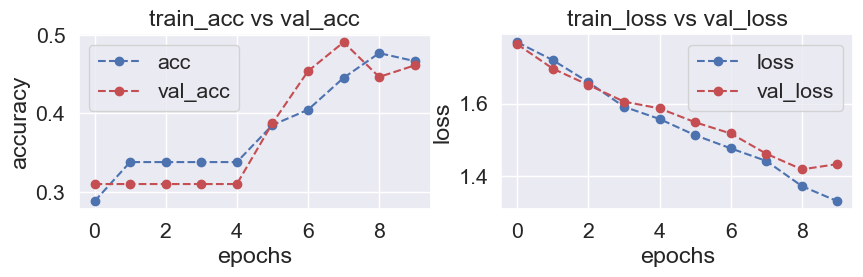

In [ ]:
plot_accuracy_loss(history)

In [ ]:
from sklearn.metrics import accuracy_score

predictions = new_model.predict(test_features)    
pred_labels = np.argmax(predictions, axis = 1)
print("Accuracy : {}".format(accuracy_score(test_labels, pred_labels)))

3/3 [==============================] - 1s 113ms/step
Accuracy : 0.5135135135135135
